# Index
<a id='top'></a>
 <ul style="list-style-type:disc">
    <li><a href='#imports'>Imports</a></li>
<li><a href='#rea'>Resources</a></li>    
  <li><a href='#functions'>Functions</a></li>
  <li><a href='#ref'>Reference Paper</a></li>    
  <li><a href='#intro'>Introduction</a></li>    
  <li><a href='#grabdata'>Data Import</a></li>
  <li><a href='#datablend'>Joining And Aggregating Data</a></li>
      <li><a href='#morefunctions'>More Functions</a></li>
  <li><a href='#poc'>Proof of Concept</a>
    <ul style="list-style-type:disc">
           <li><a href='#m1'>Model 1</a></li>
           <li><a href='#m2'>Model 2</a></li></ul>   </li>
    <li><a href='#lr'>Weather and Feature Models</a>
       <ul style="list-style-type:disc">
           <li><a href='#lr'>Linear Regression</a></li>
           <li><a href='#gbr'>Gradient Boosted Regressor</a></li>
           <li><a href='#nn'>Neural Net</a></li> 
       </ul></li>
    <li><a href='#comb'>Combined Models</a>
    <ul style="list-style-type:disc">
           <li><a href='#2hw'>2 Hour Weather Model</a></li>
           <li><a href='#mod'>Preparing Weather Data for Meta-Model</a></li> 
           <li><a href='#refpap'>Replicating Reference Paper</a></li> 
           <li><a href='#refpap'>Predicting Using Daily Period</a></li> 
            <li><a href='#success'>Predicting Using Bi-Hourly Period</a></li>
        </ul></li>
    <li><a href='#results'>Results</a></li>
    <li><a href='#disc'>Discussion</a></li>

    
 

# Imports
<a id='imports'></a>
<a href='#top'>Back to Top</a>

In [1]:
# keras imports

from keras.layers import Input, Dense, Layer, Add, Flatten, Conv2D, Conv3D, BatchNormalization, Activation, Multiply, concatenate, Concatenate
from keras.optimizers import Adam, RMSprop
from keras.initializers import he_normal, he_uniform
from keras.models import Model
from keras.losses import mse, categorical_crossentropy
from keras.utils import to_categorical
from keras.metrics import categorical_accuracy, binary_crossentropy
from keras.callbacks import ModelCheckpoint


import keras.backend as K
from keras import initializers

Using TensorFlow backend.


In [2]:
# tools
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 54)
import matplotlib.pyplot as plt

from scipy import interpolate

In [3]:
# sklearn
import sklearn as sk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor

In [4]:
# python imports
from datetime import date, datetime, timedelta
import math
import itertools
import copy
import os
import calendar
import pickle
import warnings
warnings.filterwarnings('ignore')

# Resources
<a id='ires'></a>
<a href='#top'>Back to Top</a>


http://www.math.ucla.edu/~bertozzi/papers/DeepLearningNOLTA2017.pdf

- crime prediction paper showing good results using ST-ResNet,

https://arxiv.org/pdf/1610.00081.pdf

 - Paper proposing of ST-ResNet. how it works ect. Came from microsoft research. 

# Introduction
<a id='intro'></a>
<a href='#top'>Back to Top</a>

For this project I am going to attempt to predict crime in the City of Toronto. My research question is:
Given a specific time and place in Toronto, how much crime can we expect that area to experience.

In order to solve this problem I attempted to replicate the above reference paper. I modified a couple of the methods and techniques.

The process was as follows:
1. Create city wide crime heat maps for a variety of aggregated time periods.
2. Create a model which predicts crime levels based on weather and date/time features.
3. Create a model which predicts future crime maps based on crime maps from previous periods. The architecture for this model is presented below.
4. Create a meta-model which combines the outputs of the crime map model and weather/date/time model.
5. Attempt to measure efficacy of meta-model.

### The Neural Network Architecture

<img src='Model.jpg'>


# Functions
<a id='functions'>

The below functions are used to turn a list of crimes with locations into 2D heat maps aggregated over a variety of periods. 1 hour, 2 hours, 1 day, 2 days, ect.

In [6]:
def make_grid(data,y_min,x_min,distance):
    data['grid row'] = (data['Lat'].values-y_min)//distance
    data['grid column'] = (data['Long'].values-x_min)//distance
    return data

## Grab My Data
<a id='grabdata'></a>
<a href='#top'>Back to Top</a>

### Hourly Weather Data

First I will import weather data and modify it some so that it is easy to work with

In [8]:
# import the hourly weather data into a data frame. 

#list the files
filelist = os.listdir('hourly/') 
#read them into pandas
df_list = [pd.read_csv('hourly/' + file, parse_dates=[0], skiprows=15) for file in filelist]
#concatenate them together
big_df = pd.concat(df_list, sort=False)

In [9]:
big_df['Month'].unique()

array([ 9,  4, 10,  1,  7, 12, 11,  6,  3,  2,  5,  8])

In [10]:
# fill in missing temperatures. 

big_df['Temp (°C)'] = big_df['Temp (°C)'].fillna(method='ffill')

# create a new column called avg temp to be used later. 
big_df['Avg Temp (°C)'] = big_df['Temp (°C)']

In [11]:
# average temps for each hour (0-24) of each month.

avg_temps = big_df.groupby(['Month','Time']).mean().reset_index()[['Month','Time','Avg Temp (°C)']]

In [12]:
big_df = big_df.merge(avg_temps, on=['Month','Time'], how='left')

In [13]:
big_df.dropna(axis=1, inplace=True)

In [14]:
big_df.head(1)

,Date/Time,Year,Month,Day,Time,Temp (°C),Avg Temp (°C)_x,Avg Temp (°C)_y
0,2015-09-01,2015,9,1,00:00,20.5,20.5,17.670833


In [15]:
# I suspect the difference between the absolute temperature and the average temperature may have some significance. 
big_df['delta'] = big_df['Avg Temp (°C)_y'] - big_df['Temp (°C)']

In [16]:
big_df.head(3)

,Date/Time,Year,Month,Day,Time,Temp (°C),Avg Temp (°C)_x,Avg Temp (°C)_y,delta
0,2015-09-01 00:00:00,2015,9,1,00:00,20.5,20.5,17.670833,-2.829167
1,2015-09-01 01:00:00,2015,9,1,01:00,21.4,21.4,17.336667,-4.063333
2,2015-09-01 02:00:00,2015,9,1,02:00,20.8,20.8,17.008333,-3.791667


In [17]:
big_df.set_index('Date/Time', inplace=True)

In [18]:
big_df.head(1)

,Year,Month,Day,Time,Temp (°C),Avg Temp (°C)_x,Avg Temp (°C)_y,delta
Date/Time,,,,,,,,
2015-09-01,2015,9,1,00:00,20.5,20.5,17.670833,-2.829167


### Toronto Crime Data

Import crime data.

In [19]:
# import toronto crime data
toronto_crime = pd.read_csv('MCI_2014_to_2017.csv')

In [20]:
toronto_crime['occurrencedate'] = pd.to_datetime(toronto_crime['occurrencedate'])
toronto_crime['occurrencedate']= toronto_crime['occurrencedate'].dt.normalize()

In [21]:
toronto_crime.head(1)

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,FID
0,-79.520401,43.768829,14601,GO-20142775022,2014-08-25,2014-08-25T04:00:00.000Z,Outside,1430,100,Assault,2014,August,25,237,Monday,18,2014.0,August,25.0,237.0,Monday,18,Assault,D31,24,Black Creek (24),43.768829,-79.520401,14001


# Joining And Aggregating Data
<a id='datablend'>
    <a href='#top'>Back to Top</a>
    
Below I join and aggregate the crime data with the weather data.

In [22]:
# occurrencehour will become period when hours are combined
# create  a new df which aggregates crimes by the hour in the period in which they occured. I will loose location data
# but this df will be used to help find paterns between weather, DOW, DOY, HOD ect. and crime. 

grouped_1_hour = toronto_crime.groupby(['occurrenceyear','occurrencemonth',
                          'occurrenceday','occurrencedayofweek','occurrencehour']).count().reset_index()

grouped_1_hour['year'] = grouped_1_hour['occurrenceyear']
grouped_1_hour['month'] = pd.to_datetime(grouped_1_hour['occurrencemonth'], format='%B').dt.month
grouped_1_hour['day'] = grouped_1_hour['occurrenceday']

grouped_1_hour['date'] = pd.to_datetime(grouped_1_hour[['year','month','day']])

In [23]:
#grouped_1_hour['date'] = pd.to_datetime(grouped_1_hour[['date','occurrencehour']])
grouped_1_hour.head(10)

,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofweek,occurrencehour,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrencedayofyear,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,FID,year,month,day,date
0,2000.0,August,1.0,Tuesday,12,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2000.0,8,1.0,2000-08-01
1,2000.0,February,1.0,Tuesday,10,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2000.0,2,1.0,2000-02-01
2,2000.0,January,1.0,Saturday,0,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,2000.0,1,1.0,2000-01-01
3,2000.0,January,1.0,Saturday,10,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2000.0,1,1.0,2000-01-01
4,2000.0,January,1.0,Saturday,12,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2000.0,1,1.0,2000-01-01
5,2000.0,January,1.0,Saturday,23,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2000.0,1,1.0,2000-01-01
6,2000.0,November,22.0,Wednesday,8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2000.0,11,22.0,2000-11-22
7,2000.0,October,1.0,Sunday,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2000.0,10,1.0,2000-10-01
8,2001.0,January,1.0,Monday,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2001.0,1,1.0,2001-01-01
9,2001.0,January,1.0,Monday,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2001.0,1,1.0,2001-01-01


In [24]:
big_df.head(1)

,Year,Month,Day,Time,Temp (°C),Avg Temp (°C)_x,Avg Temp (°C)_y,delta
Date/Time,,,,,,,,
2015-09-01,2015,9,1,00:00,20.5,20.5,17.670833,-2.829167


In [25]:
# Joining my aggregated crime list with the weather df

grouped_crime_ww = grouped_1_hour.join(big_df[['Temp (°C)','delta']], on='date')

In [26]:
grouped_crime_ww.dropna(inplace=True)
grouped_crime_ww['hour'] = grouped_crime_ww.occurrencehour
grouped_crime_ww.occurrencehour = pd.to_timedelta(grouped_crime_ww.occurrencehour, unit='h')
grouped_crime_ww = grouped_crime_ww.set_index('date')
grouped_crime_ww.index = grouped_crime_ww.index + grouped_crime_ww.occurrencehour
#df.index.name = 'Date'

grouped_crime_ww

,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofweek,occurrencehour,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrencedayofyear,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,FID,year,month,day,Temp (°C),delta,hour
2014-04-01 00:00:00,2014.0,April,1.0,Tuesday,00:00:00,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,2014.0,4,1.0,2.4,2.953333,0
2014-04-01 01:00:00,2014.0,April,1.0,Tuesday,01:00:00,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,2014.0,4,1.0,2.4,2.953333,1
2014-04-01 02:00:00,2014.0,April,1.0,Tuesday,02:00:00,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2014.0,4,1.0,2.4,2.953333,2
2014-04-01 03:00:00,2014.0,April,1.0,Tuesday,03:00:00,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2014.0,4,1.0,2.4,2.953333,3
2014-04-01 05:00:00,2014.0,April,1.0,Tuesday,05:00:00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2014.0,4,1.0,2.4,2.953333,5
2014-04-01 07:00:00,2014.0,April,1.0,Tuesday,07:00:00,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,2014.0,4,1.0,2.4,2.953333,7
2014-04-01 08:00:00,2014.0,April,1.0,Tuesday,08:00:00,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,2014.0,4,1.0,2.4,2.953333,8
2014-04-01 09:00:00,2014.0,April,1.0,Tuesday,09:00:00,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,2014.0,4,1.0,2.4,2.953333,9
2014-04-01 10:00:00,2014.0,April,1.0,Tuesday,10:00:00,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,2014.0,4,1.0,2.4,2.953333,10
2014-04-01 11:00:00,2014.0,April,1.0,Tuesday,11:00:00,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2014.0,4,1.0,2.4,2.953333,11


In [27]:
grouped_crime_ww = grouped_crime_ww.sort_index()

In [28]:
# new df to use in my linear model.
lin_mod_data = grouped_crime_ww[['occurrencemonth','occurrencedayofweek', 'occurrencehour','Temp (°C)', 'delta','hour','event_unique_id']]

In [29]:
lin_mod_data.head(2)

,occurrencemonth,occurrencedayofweek,occurrencehour,Temp (°C),delta,hour,event_unique_id
2014-01-01 00:00:00,January,Wednesday,00:00:00,-8.3,4.206452,0,65
2014-01-01 01:00:00,January,Wednesday,01:00:00,-8.3,4.206452,1,15


In [30]:
# crime/weather data aggregated into two hour groups
lin_mod_data_2 = grouped_crime_ww[['occurrencemonth','occurrencedayofweek', 'occurrencehour','Temp (°C)', 'delta','hour','event_unique_id','occurrenceyear']].copy(deep=True)
lin_mod_data_2['period'] = lin_mod_data_2['hour']//2
lin_mod_data_2 = lin_mod_data_2.groupby(['occurrenceyear','occurrencemonth','occurrencedayofweek','period']).sum().reset_index()
lin_mod_data_2['new temp'] = lin_mod_data_2['Temp (°C)']/2
lin_mod_data_2['new delta'] = lin_mod_data_2['delta']/2


In [31]:
lin_mod_data_2.head(12)

,occurrenceyear,occurrencemonth,occurrencedayofweek,period,Temp (°C),delta,hour,event_unique_id,new temp,new delta
0,2014.0,April,Friday,0,37.2,5.626667,4,27,18.60,2.813333
1,2014.0,April,Friday,1,37.2,5.626667,20,28,18.60,2.813333
2,2014.0,April,Friday,2,35.3,2.173333,32,14,17.65,1.086667
3,2014.0,April,Friday,3,33.4,-1.280000,39,11,16.70,-0.640000
4,2014.0,April,Friday,4,32.7,4.773333,60,23,16.35,2.386667
5,2014.0,April,Friday,5,37.2,5.626667,84,22,18.60,2.813333
6,2014.0,April,Friday,6,37.2,5.626667,100,35,18.60,2.813333
7,2014.0,April,Friday,7,37.2,5.626667,116,37,18.60,2.813333
8,2014.0,April,Friday,8,37.2,5.626667,132,34,18.60,2.813333
9,2014.0,April,Friday,9,35.3,2.173333,129,32,17.65,1.086667


In [32]:
# in big_df need to add a period column and then group by year, month, day, period, mean so i can slice 
# that df for data for models. 

In [33]:
big_df.head(2)

,Year,Month,Day,Time,Temp (°C),Avg Temp (°C)_x,Avg Temp (°C)_y,delta
Date/Time,,,,,,,,
2015-09-01 00:00:00,2015,9,1,00:00,20.5,20.5,17.670833,-2.829167
2015-09-01 01:00:00,2015,9,1,01:00,21.4,21.4,17.336667,-4.063333


In [34]:
# the lin_mod_data_2 df can be used for creating models on just the features in that df. However it can't easily 
# be queried for use in the larger meta model. Below I create a df that can easily be queried for use in the larger
# meta model. 

extra_features = big_df.copy(deep=True)
extra_features['DOW'] = extra_features.index.dayofweek
times = extra_features['Time'].str.split(':').values
times = [item[0] for item in times]
extra_features['Hour'] = times
extra_features['Hour'] = pd.to_numeric(extra_features['Hour'])
extra_features['period'] = extra_features['Hour']//2

In [35]:
extra_features = extra_features.groupby(['Year','Month','Day','period']).mean().reset_index()
extra_features['date'] = pd.to_datetime(extra_features[['Year','Month','Day']])
extra_features = extra_features.set_index('date')

In [36]:
extra_features['Month'] = extra_features['Month'].apply(lambda x: calendar.month_abbr[x])

In [37]:
extra_features['DOW'] = extra_features['DOW'].astype(int)

In [38]:
extra_features['DOW'] = extra_features['DOW'].apply(lambda x: calendar.day_abbr[x])

In [39]:
extra_features.head(3)

,Year,Month,Day,period,Temp (°C),Avg Temp (°C)_x,Avg Temp (°C)_y,delta,DOW,Hour
date,,,,,,,,,,
2014-01-01,2014,Jan,1,0,-8.25,-8.25,-4.173387,4.076613,Wed,0.5
2014-01-01,2014,Jan,1,1,-8.70,-8.70,-4.362500,4.337500,Wed,2.5
2014-01-01,2014,Jan,1,2,-9.00,-9.00,-4.499194,4.500806,Wed,4.5


In [40]:
(12*365)+(12*365)+(12*365)+(12*366)

17532

In [41]:
toronto_crime_date_indexed = toronto_crime.set_index('occurrencedate')
toronto_crime_date_indexed.head(2)

,X,Y,Index_,event_unique_id,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,FID
occurrencedate,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-08-25,-79.520401,43.768829,14601,GO-20142775022,2014-08-25T04:00:00.000Z,Outside,1430,100,Assault,2014,August,25,237,Monday,18,2014.0,August,25.0,237.0,Monday,18,Assault,D31,24,Black Creek (24),43.768829,-79.520401,14001
2014-08-25,-79.580856,43.642574,14602,GO-20142870874,2014-09-08T04:00:00.000Z,House,2120,220,B&E W'Intent,2014,September,8,251,Monday,22,2014.0,August,25.0,237.0,Monday,9,Break and Enter,D22,11,Eringate-Centennial-West Deane (11),43.642574,-79.580856,14002


# More Functions
<a id='morefunctions'>
    <a href='#top'>Back to Top</a>

In [42]:
def normalize_map(maps, one_val, zero_val):
    '''
    This is a Min-Max Scaler
    takes -  singlemaps, one_val, zero_val
    returns - return maps
    '''
#     te_max, te_min = test_maps.max(), test_maps.min()
#     tr_max, tr_min = train_maps.max(), train_maps.max()
#     one_val = max(te_max, tr_max)
#     zero_val = min(te_min, tr_min)
    maps = (maps - zero_val)/(one_val-zero_val)

    return maps

In [43]:
def normalize(data,data2, column):
    '''
    This is a Min-Max Scaler.  
    this takes a pandas df as input and returns a df with columns values closer to between -1 and 1. It may not return 
    values exactly between -1 and 1, because that is not required by NN's, just close.

    
    current value - value at zero/ value at one - value at zero 
    
    '''
    zero_vals = []
    one_vals = []
    for c in column:
        zero_val = data[c].min()
        one_val = data[c].max()
        data[c] = (data[c] - zero_val)/(one_val-zero_val)
        data2[c] = (data2[c] - zero_val)/(one_val-zero_val)
        zero_vals.append(zero_val)
        one_vals.append(one_val)
    return data, data2, zero_vals, one_vals

In [44]:
def dummy_me(data,columns_to_dummy):
    '''
    Takes a data frame and returns the same frame with added dummy columns. does not remove the column that
    generated dummies. 
    '''
    
    for c in columns_to_dummy:
        c_dummy = pd.get_dummies(data[c])
        data = pd.concat([data,c_dummy], axis=1)
    return data

# Weather and Calendar Feature Models

### Linear Regression Model

<a id='lr'>
    <a href='#top'>Back to Top<a/>

Below I try to create a model which predicts crime amounts based on weather/time/date features. The idea is that this model will be combined with the CNN which predicts based on crime maps.



In [45]:
lin_mod_data.head(2)

,occurrencemonth,occurrencedayofweek,occurrencehour,Temp (°C),delta,hour,event_unique_id
2014-01-01 00:00:00,January,Wednesday,00:00:00,-8.3,4.206452,0,65
2014-01-01 01:00:00,January,Wednesday,01:00:00,-8.3,4.206452,1,15


In [46]:
encode = LabelEncoder()
mon = encode.fit_transform(lin_mod_data['occurrencemonth'])
week = encode.fit_transform(lin_mod_data['occurrencedayofweek'])

In [47]:
lin_mod_data['month'] = mon
lin_mod_data['dow'] = week

In [48]:
lin_mod_data.head(2)

,occurrencemonth,occurrencedayofweek,occurrencehour,Temp (°C),delta,hour,event_unique_id,month,dow
2014-01-01 00:00:00,January,Wednesday,00:00:00,-8.3,4.206452,0,65,4,6
2014-01-01 01:00:00,January,Wednesday,01:00:00,-8.3,4.206452,1,15,4,6


In [49]:
train = lin_mod_data.loc[:'2017-01-01 00:00:00']

In [50]:
test = lin_mod_data.loc['2017-01-01 00:00:00':'2017-01-08 00:00:00']

In [51]:
test_feature = test[[#'occurrencemonth',
                     #'occurrencedayofweek',
              #'occurrencehour',
                'hour',
              'Temp (°C)',
              'delta',
                     'month',
                     'dow'
               ]].values

test_target = test['event_unique_id'].values

In [52]:
train_feature = train[[#'occurrencemonth',
                     #'occurrencedayofweek',
              #'occurrencehour', 
                'hour',
              'Temp (°C)',
              'delta',
                    'month',
                    'dow'
               ]].values

train_target = train['event_unique_id'].values

In [53]:
weather_predict = LinearRegression()
weather_predict.fit(train_feature,train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [54]:
weather_predict.score(train_feature,train_target)

0.02889253305013806

The simple LinearRegression model performs poorly, even on training data.

### Gradient Boosted Regressor
<a id='gbr'>
    <a href='#top'>Back to Top<a/>

Below I try two more complicated regression models. A gradient boosted tree regressor and a simple neural net.

In [55]:
weather_treepredict = GradientBoostingRegressor()
weather_treepredict.fit(train_feature,train_target)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [56]:
weather_treepredict.score(train_feature,train_target)

0.19269080052488874

In [57]:
lin_mod_data.head(1)

,occurrencemonth,occurrencedayofweek,occurrencehour,Temp (°C),delta,hour,event_unique_id,month,dow
2014-01-01,January,Wednesday,0 days,-8.3,4.206452,0,65,4,6


In [58]:
lin_mod_data.head(2)
one_hot_master = dummy_me(lin_mod_data, ['occurrencemonth', 'occurrencedayofweek','hour'])

In [59]:
one_hot_master.columns

Index([    'occurrencemonth', 'occurrencedayofweek',      'occurrencehour',
                 'Temp (°C)',               'delta',                'hour',
           'event_unique_id',               'month',                 'dow',
                     'April',              'August',            'December',
                  'February',             'January',                'July',
                      'June',               'March',                 'May',
                  'November',             'October',           'September',
                'Friday    ',          'Monday    ',          'Saturday  ',
                'Sunday    ',          'Thursday  ',          'Tuesday   ',
                'Wednesday ',                     0,                     1,
                           2,                     3,                     4,
                           5,                     6,                     7,
                           8,                     9,                    10,
            

In [60]:
one_hot_master.columns
one_hot_master = one_hot_master[['Temp (°C)', 'delta', 'event_unique_id','April','August','December','February',             'January',                'July',
                      'June', 'March', 'May', 'November','October', 'September', 'Friday    ', 'Monday    ',
                                 'Saturday  ', 'Sunday    ', 'Thursday  ', 'Tuesday   ', 'Wednesday ',0,                     1,
                           2,                     3,                     4,
                           5,                     6,                     7,
                           8,                     9,                    10,
                          11,                    12,                    13,
                          14,                    15,                    16,
                          17,                    18,                    19,
                          20,                    21,                    22,
                          23]]

In [61]:
train_one_hot = one_hot_master.loc[:'2017-01-01 00:00:00']
test_one_hot = one_hot_master.loc['2017-01-01 00:00:00':'2017-01-08 00:00:00']

In [62]:
oh_test_feature = test_one_hot[['Temp (°C)', 'delta', 'April','August','December','February',             'January',                'July',
                      'June', 'March', 'May', 'November','October', 'September', 'Friday    ', 'Monday    ',
                                 'Saturday  ', 'Sunday    ', 'Thursday  ', 'Tuesday   ', 'Wednesday ',0,                     1,
                           2,                     3,                     4,
                           5,                     6,                     7,
                           8,                     9,                    10,
                          11,                    12,                    13,
                          14,                    15,                    16,
                          17,                    18,                    19,
                          20,                    21,                    22,
                          23]]

oh_test_target = test_one_hot['event_unique_id'].values


oh_train_feature = train_one_hot[['Temp (°C)', 'delta', 'April','August','December','February',             'January',                'July',
                      'June', 'March', 'May', 'November','October', 'September', 'Friday    ', 'Monday    ',
                                 'Saturday  ', 'Sunday    ', 'Thursday  ', 'Tuesday   ', 'Wednesday ',0,                     1,
                           2,                     3,                     4,
                           5,                     6,                     7,
                           8,                     9,                    10,
                          11,                    12,                    13,
                          14,                    15,                    16,
                          17,                    18,                    19,
                          20,                    21,                    22,
                          23]]

oh_train_target = train_one_hot['event_unique_id'].values

In [63]:
weather_treepredict_2 = GradientBoostingRegressor()
weather_treepredict_2.fit(oh_train_feature,oh_train_target)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [64]:
weather_treepredict_2.score(oh_train_feature,oh_train_target)

0.16153959632300807

#### Gradient Boosted Regressor GridSearch

In [65]:
parameters = {'loss' : ['ls', 'lad', 'huber', 'quantile'], 
              'learning_rate' : [.01, .05, .1, .15, .25, .5],
             'n_estimators' : [100, 500, 1000, 2500],
              'min_samples_leaf' : [1 ,5, 10, 20],
              'max_depth' : [1, 3, 7, 10]
             }
gtr = GradientBoostingRegressor()
gtr2 = GradientBoostingRegressor()
gm = GridSearchCV(gtr, parameters, cv=4)
gm2 = GridSearchCV(gtr, parameters, cv=4)

#### This was taxing to run. The results are gone. No parameter mix improved the models score meaningfully

### Neural Network
<a id='nn'>
    <a href='#top'>Back to Top<a/>

In [66]:
# here I min max scale my data - with a function from above.

nn_feat_weather_train,nn_feat_weather_test,_,_ = normalize(oh_train_feature,oh_test_feature,['Temp (°C)', 'delta'])

weather_network = MLPRegressor((50,50,50,50,),early_stopping=True)


In [67]:
%%time
weather_network.fit(nn_feat_weather_train, oh_train_target)

CPU times: user 7.39 s, sys: 2.34 s, total: 9.73 s
Wall time: 4.89 s


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [68]:
weather_network.score(nn_feat_weather_train, oh_train_target)

0.20760288059467183

In [69]:
weather_network.score(nn_feat_weather_test, oh_test_target)

0.18674231573017708

The neural net and gradient boosted tree perform similarly. In the meta model I will be utilizing the NN. The source paper uses a neural net and I want to stay as close as possible to the source methodology. 

# Combined Models
<a id='comb'></a>
<a href='#top'>Back to Top</a>

# Weather and Extra Feature Models

## 2 hour model
<a id='2hw'></a>
<a href='#top'>Back to Top</a>

Some models to predict crime based on time and weather features. However, these are not time series models. First set of models predict on 2 hour aggregation periods, second set 6 hour aggregation periods. 

In [70]:
# 2 hour data
lin_mod_data_2.head(2)
one_hot_master_two = dummy_me(lin_mod_data_2, ['occurrencemonth', 'occurrencedayofweek','period'])

In [71]:
lin_mod_data_2.head(3)

,occurrenceyear,occurrencemonth,occurrencedayofweek,period,Temp (°C),delta,hour,event_unique_id,new temp,new delta
0,2014.0,April,Friday,0,37.2,5.626667,4,27,18.60,2.813333
1,2014.0,April,Friday,1,37.2,5.626667,20,28,18.60,2.813333
2,2014.0,April,Friday,2,35.3,2.173333,32,14,17.65,1.086667


In [72]:
one_hot_master_two.columns

Index([     'occurrenceyear',     'occurrencemonth', 'occurrencedayofweek',
                    'period',           'Temp (°C)',               'delta',
                      'hour',     'event_unique_id',            'new temp',
                 'new delta',               'April',              'August',
                  'December',            'February',             'January',
                      'July',                'June',               'March',
                       'May',            'November',             'October',
                 'September',          'Friday    ',          'Monday    ',
                'Saturday  ',          'Sunday    ',          'Thursday  ',
                'Tuesday   ',          'Wednesday ',                     0,
                           1,                     2,                     3,
                           4,                     5,                     6,
                           7,                     8,                     9,
            

In [73]:
one_hot_master_two = one_hot_master_two[['occurrenceyear','new temp', 'new delta', 'event_unique_id','April','August','December','February',             'January',                'July',
                      'June', 'March', 'May', 'November','October', 'September', 'Friday    ', 'Monday    ',
                                 'Saturday  ', 'Sunday    ', 'Thursday  ', 'Tuesday   ', 'Wednesday ',0,                     1,
                           2,                     3,                     4,
                           5,                     6,                     7,
                           8,                     9,                    10,
                          11]]

In [74]:
train = one_hot_master_two[(one_hot_master_two['occurrenceyear'] == 2014) |(one_hot_master_two['occurrenceyear'] == 2015)]
test = one_hot_master_two[(one_hot_master_two['occurrenceyear'] == 2016)]

In [75]:
train_target = train['event_unique_id']
train_feature = train[['new temp', 'new delta','April','August','December','February',             'January',                'July',
                      'June', 'March', 'May', 'November','October', 'September', 'Friday    ', 'Monday    ',
                                 'Saturday  ', 'Sunday    ', 'Thursday  ', 'Tuesday   ', 'Wednesday ',0,                     1,
                           2,                     3,                     4,
                           5,                     6,                     7,
                           8,                     9,                    10,
                          11]]

In [76]:
test_target = test['event_unique_id']
test_feature = test[['new temp', 'new delta','April','August','December','February',             'January',                'July',
                      'June', 'March', 'May', 'November','October', 'September', 'Friday    ', 'Monday    ',
                                 'Saturday  ', 'Sunday    ', 'Thursday  ', 'Tuesday   ', 'Wednesday ',0,                     1,
                           2,                     3,                     4,
                           5,                     6,                     7,
                           8,                     9,                    10,
                          11]]

In [77]:
train_feature, test_feature, zero_w, one_w = normalize(train_feature,test_feature,['new temp', 'new delta'])


weather_network = MLPRegressor((50,50,50,50,),early_stopping=True)

### 2 Hour Weather and Feature Model Results

In [78]:
weather_network.fit(train_feature, train_target)
print(weather_network.score(train_feature, train_target))
print(weather_network.score(test_feature, test_target))

0.7551726841433324
0.5668790259679533


Improved performance by modeling on 2 hour aggregated periods instead of 1 hour periods.

#### Modifying Weather Data For Use in Meta-Model
<a id='mod'></a>
<a href='#top'>Back to Top</a>

In [80]:
# of particular importance is to make sure the features are scaled appropriatly. 

extra_feature_encode = extra_features[['Temp (°C)','delta','Month','DOW','period']].copy(deep=True)
extra_feature_encode = dummy_me(extra_feature_encode,['Month','DOW','period'])
extra_feature_encode['Temp (°C)'] = (extra_feature_encode['Temp (°C)'] - zero_w[0])/(one_w[0]-zero_w[0])
extra_feature_encode['delta'] = (extra_feature_encode['delta'] - zero_w[0])/(one_w[0]-zero_w[0])
extra_feature_encode.columns

Index(['Temp (°C)',     'delta',     'Month',       'DOW',    'period',
             'Apr',       'Aug',       'Dec',       'Feb',       'Jan',
             'Jul',       'Jun',       'Mar',       'May',       'Nov',
             'Oct',       'Sep',       'Fri',       'Mon',       'Sat',
             'Sun',       'Thu',       'Tue',       'Wed',           0,
                 1,           2,           3,           4,           5,
                 6,           7,           8,           9,          10,
                11],
      dtype='object')

In [81]:
extra_feature_encode = extra_feature_encode[['Temp (°C)',     'delta',
             'Apr',       'Aug',       'Dec',       'Feb',       'Jan',
             'Jul',       'Jun',       'Mar',       'May',       'Nov',
             'Oct',       'Sep',       'Fri',       'Mon',       'Sat',
             'Sun',       'Thu',       'Tue',       'Wed',           0,
                 1,           2,           3,           4,           5,
                 6,           7,           8,           9,          10,
                11]]

In [82]:
len(extra_feature_encode)

17532

# Combined Meta Model
<a id='refpap'></a>
<a href='#top'>Back to Top</a>

### Model 1 - Predicting Using Daily Periods

In the reference paper past crime maps where passed to the model as multiple maps stacked into 3D images. Below I replicate that methodology. Next is a diagram visualizing the data structure used in this model. 


<img src='second data structure.jpg'>

I will start by inputing just daily and weekly data to see how the model performs. 

### Creating the inputs

In [83]:
jan_nov_2017 = toronto_crime_date_indexed.loc['2017-01-01':'2017-11-30']

In [84]:
def simple_make_maps(data,rows,periods):
    '''
    If daily is true returns daily heat maps, set period size 7 if you want weekly maps
    if daily is false returns hourly heat maps, set period size 2 if you want 2 hours of crimes combined ect.
    '''

    # new way
    x_max, x_min = toronto_crime['X'].max(), toronto_crime['X'].min()
    y_max, y_min = toronto_crime['Y'].max(), toronto_crime['Y'].min()
    

    d = (y_max-y_min)/rows
    cols = math.ceil((x_max-x_min)/d)
    
    #below adds grid locations to data. you could always add a more complex gridding function here. 
    data = make_grid(data,y_min,x_min,d)
    
    # trying to make daily crime maps
#     data['day of period'] = data.apply(fun, axis=1).values
#     data['adjusted period'] = data['day of period']//period_size                
#     data_grouped = data.groupby(['adjusted period','grid row', 'grid column']).count()
    #trying to make year of daily crime maps. 
        
        
    data_grouped = data.groupby(['occurrencedayofyear','grid row', 'grid column']).count()
       
    crime_pic = np.zeros((periods, rows, cols))
    for i,p in enumerate(range(1,336)):
        for r in range(rows):
            for c in range(cols):
                try:
                    value = data_grouped.at[(p,r,c),'event_unique_id']
                    crime_pic[i,r,c] = int(value) 
                except:
                    pass

    
    crime_pic = np.flip(crime_pic,1)
    
    
    return crime_pic

In [85]:
all_daily_map = simple_make_maps(jan_nov_2017,8,334)

In [86]:
weekly_maps_2017 = []
daily_maps_2017 = []
targets_2017 = []
for x in range(300):
    wholder = []
    w1 = np.sum(all_daily_map[0+x:7+x],axis=0)
    w2 = np.sum(all_daily_map[7+x:14+x],axis=0)
    w3 = np.sum(all_daily_map[14+x:21+x],axis=0)
    wholder.append(w1)
    wholder.append(w2)
    wholder.append(w3)
    weekly_maps_2017.append(wholder)
    
    dholder = []
    d1 = all_daily_map[17+x:18+x].reshape(8,16)
    d2 = all_daily_map[18+x:19+x].reshape(8,16)
    d3 = all_daily_map[19+x:20+x].reshape(8,16)
    d4 = all_daily_map[20+x:21+x].reshape(8,16)
    dholder.append(d1)
    dholder.append(d2)
    dholder.append(d3)
    dholder.append(d4)
    daily_maps_2017.append(dholder)
    
    targets = []
    t = all_daily_map[21+x:22+x]
    t = t.reshape(128)

    targets_2017.append(t)

weekly_stack = np.stack(weekly_maps_2017,axis=0)
daily_stack = np.stack(daily_maps_2017,axis=0)
targets_2017 = np.stack(targets_2017,axis=0)

In [87]:
# minmax scaling 

w_max = weekly_stack.max()
w_min = weekly_stack.min()
d_max = daily_stack.max()
d_min = daily_stack.min()

In [88]:
weekly_stack = (weekly_stack - w_min)/(w_max-w_min)
daily_stack = (daily_stack - d_min)/(d_max-d_min)
targets_2017 = (targets_2017 - d_min)/(d_max-d_min)

In [89]:
weekly_train, weekly_val, weekly_test = weekly_stack[:200], weekly_stack[200:250], weekly_stack[250:300]

In [90]:
daily_train, daily_val, daily_test = daily_stack[:200], daily_stack[200:250], daily_stack[250:300]

In [91]:
target_train, target_val, target_test = targets_2017[:200], targets_2017[200:250], targets_2017[250:300]

In [92]:
def ResUnit2(x,filters):
    res = x
    layer = BatchNormalization()(x)
    layer = Activation("relu")(layer)
    layer = Conv2D(filters=filters, kernel_size=[4, 4], strides=[1, 1], padding="same", data_format="channels_first")(layer)

    layer = Activation("relu")(layer)
    layer = Conv2D(filters=filters, kernel_size=[4, 4], strides=[1, 1], padding="same", data_format="channels_first")(layer)

    out = Add()([res,layer])

    return out

### The Model

In [93]:
weekly_input = Input(shape=(3,8,16))
w_layer = Conv2D(12, (4,4), activation='relu', data_format="channels_first")(weekly_input)
w_layer = ResUnit2(w_layer,12)
w_layer = ResUnit2(w_layer,12)
w_layer = ResUnit2(w_layer,12)

# daily stack
daily_input = Input(shape=(4,8,16))
d_layer = Conv2D(12, (4,4), activation='relu', data_format="channels_first")(daily_input)
d_layer = ResUnit2(d_layer,12)
d_layer = ResUnit2(d_layer,12)
d_layer = ResUnit2(d_layer,12)

#hourly stack
# hourly_input = Input(shape=(8,16,1))
# h_layer = Conv2D(12, (4,4), activation='relu')(hourly_input)
# h_layer = ResUnit2(h_layer,12)
# h_layer = ResUnit2(h_layer,12)


combined = Add()([w_layer, d_layer])
combined = Flatten()(combined)

output = Dense(128, activation='sigmoid')(combined)

st_resnet = Model(inputs=[weekly_input, daily_input], outputs = output)
st_resnet.compile('adam', loss='mse', metrics=['mse'])

In [94]:
st_resnet.fit(
    [weekly_train, daily_train], target_train, 
    epochs=25, 
    validation_data=([weekly_val, daily_val], target_val),
    callbacks=[ModelCheckpoint('tmp1.h5', save_best_only=True)]
)

Train on 200 samples, validate on 50 samples
Epoch 1/25
200/200 [==============================] - 17s 84ms/step - loss: 0.1017 - mean_squared_error: 0.1017 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 2/25
200/200 [==============================] - 0s 671us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 3/25
200/200 [==============================] - 0s 650us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 4/25
200/200 [==============================] - 0s 662us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 5/25
200/200 [==============================] - 0s 656us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 6/25
200/200 [==============================] - 0s 655us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0046 - va

In [95]:
predictions = st_resnet.predict([weekly_val, daily_val])

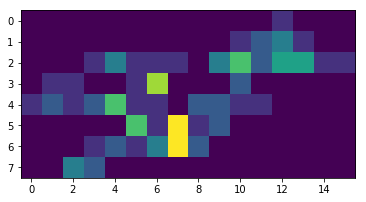

In [96]:
plt.imshow(target_val[10].reshape(8,16))

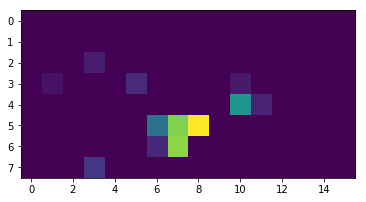

In [97]:
plt.imshow(predictions[10].reshape(8,16))

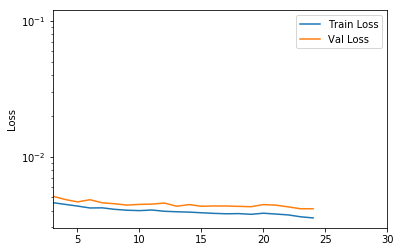

In [98]:
plt.plot(st_resnet.history.history['loss'], label='Train Loss')
plt.plot(st_resnet.history.history['val_loss'], label='Val Loss')
plt.ylabel('Loss')
plt.yscale('log')
plt.xlim(3,30)
plt.legend()
plt.show()

# Predicting Using Bi-Hourly Periods 

<a id='success'></a>
<a href='#top'>Back to Top<a/>

Below uses a complete implimentation of the previously described data structure. Above I trained the model only on weekly and daily data, below I have added daily data.

I will create two versions of the hourly map arrays. One version will just be the crime from that period, the other version will be the cumulative daily sum until that period ie. hour 3 on any given day will be cumulative sum of hour 1 2 and 3. 

<img src='second data structure.jpg'>

### creating the inputs

In [99]:
jan_nov_2017_hour = jan_nov_2017.copy(deep=True)

In [100]:
jan_nov_2017_hour.head(1)

,X,Y,Index_,event_unique_id,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,FID,grid row,grid column
occurrencedate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,-79.348106,43.687538,72601,GO-201712557,2017-01-03T05:00:00.000Z,Commercial,2120,200,B&E,2017,January,3,3,Tuesday,9,2017.0,January,1.0,1.0,Sunday,1,Break and Enter,D54,59,Danforth East York (59),43.687538,-79.348106,72012,3.0,8.0


In [101]:
def simple_hour_maps(data,rows,periods):
    '''
    Turns a list of crimes into crime maps. 
    '''
    # rows = 8 
    cols = 16
    
    # below adds the aggregated hourly period of the entire inputed data set. 
    data['period'] = ((data['occurrencedayofyear'] -1) *12) + data['occurrencehour']//2
    
    data_grouped = data.groupby(['period','grid row', 'grid column']).count()
       
    crime_pic = np.zeros((periods, rows, cols))
    for i,p in enumerate(range(1,4010)):
        for r in range(rows):
            for c in range(cols):
                try:
                    value = data_grouped.at[(p,r,c),'event_unique_id']
                    crime_pic[i,r,c] = int(value) 
                except:
                    pass

    
    crime_pic = np.flip(crime_pic,1)
    
    
    return crime_pic

In [102]:
all_hourly_maps = simple_hour_maps(jan_nov_2017_hour,8,4008)

In [103]:
def make_cumulative(new_array):
    '''
    turn an array of maps into array of same size but maps are cumulated daily
    '''
    cumlat = []
    for i in range(0,len(new_array),12):
        day_c = np.cumsum(all_hourly_maps[i:12+i:], axis=0)
        cumlat.append(day_c)
    cumlat = np.concatenate(cumlat)
    return cumlat

In [104]:
all_hourly_maps_c = make_cumulative(all_hourly_maps)

In [105]:
all_hourly_maps.shape

(4008, 8, 16)

In [106]:
all_hourly_maps_c.shape

(4008, 8, 16)

In [107]:
# Below turns the big list of bi-hourly maps into aggregated weekly, daily and hourly maps. 

hourly_maps_2017 = []
hourly_targets_2017 = []
mega_week = []
mega_daily = []
hourly_targets_2017_c = []
hourly_maps_2017_c = []
for x in range(3600):
    hholder = []
    h1 = all_hourly_maps[248+x:249+x].reshape(8,16)
    h2 = all_hourly_maps[249+x:250+x].reshape(8,16)
    h3 = all_hourly_maps[250+x:251+x].reshape(8,16)
    h4 = all_hourly_maps[251+x:252+x].reshape(8,16)
    hholder.append(h1)
    hholder.append(h2)
    hholder.append(h3)
    hholder.append(h4)
    hourly_maps_2017.append(hholder)
    
    hcholder = []
    hc1 = all_hourly_maps_c[248+x:249+x].reshape(8,16)
    hc2 = all_hourly_maps_c[249+x:250+x].reshape(8,16)
    hc3 = all_hourly_maps_c[250+x:251+x].reshape(8,16)
    hc4 = all_hourly_maps_c[251+x:252+x].reshape(8,16)
    hcholder.append(hc1)
    hcholder.append(hc2)
    hcholder.append(hc3)
    hcholder.append(hc4)
    hourly_maps_2017_c.append(hcholder)
    
    
    wholder = []
    w1 = np.sum(all_hourly_maps[x:84+x],axis=0).reshape(8,16)
    w2 = np.sum(all_hourly_maps[84+x:168+x], axis=0).reshape(8,16)
    w3 = np.sum(all_hourly_maps[168+x:252+x],axis=0).reshape(8,16)
    wholder.append(w1)
    wholder.append(w2)
    wholder.append(w3)
    mega_week.append(wholder)
    
    dholder = []
    d1 = np.sum(all_hourly_maps[203+x:215+x],axis=0).reshape(8,16)
    d2 = np.sum(all_hourly_maps[215+x:227+x],axis=0).reshape(8,16)
    d3 = np.sum(all_hourly_maps[227+x:239+x],axis=0).reshape(8,16)
    d4 = np.sum(all_hourly_maps[239+x:252+x],axis=0).reshape(8,16)
    dholder.append(d1)
    dholder.append(d2)
    dholder.append(d3)
    dholder.append(d4)
    mega_daily.append(dholder)
    
    
    th = all_hourly_maps[252+x:253+x]
    th = th.reshape(128)
    hourly_targets_2017.append(th)
    
    thc = all_hourly_maps_c[252+x:253+x]
    thc = thc.reshape(128)
    hourly_targets_2017_c.append(thc)
    
mega_daily = np.stack(mega_daily,axis=0)
mega_week = np.stack(mega_week,axis=0)
hourly_maps_2017 = np.stack(hourly_maps_2017,axis=0)
hourly_targets_2017 = np.stack(hourly_targets_2017,axis=0)
hourly_maps_2017_c = np.stack(hourly_maps_2017_c, axis=0)
hourly_targets_2017_c = np.stack(hourly_targets_2017_c, axis=0)

In [108]:
hourly_targets_2017_c.shape

(3600, 128)

In [ ]:
# min max scaling below. 

In [110]:
hourly_maps_2017_c_train, hourly_maps_2017_c_val, hourly_maps_2017_c_test = hourly_maps_2017_c[:3000], hourly_maps_2017_c[3000:3300], hourly_maps_2017_c[3300:3600]
hourly_targets_2017_c_train, hourly_targets_2017_c_val, hourly_targets_2017_c_test = hourly_targets_2017_c[:3000], hourly_targets_2017_c[3000:3300], hourly_targets_2017_c[3300:3600]
hourly_maps_2017_train, hourly_maps_2017_val, hourly_maps_2017_test = hourly_maps_2017[:3000], hourly_maps_2017[3000:3300], hourly_maps_2017[3300:3600]
hourly_targets_2017_train, hourly_targets_2017_val, hourly_targets_2017_test = hourly_targets_2017[:3000], hourly_targets_2017[3000:3300], hourly_targets_2017[3300:3600]
mega_daily_train, mega_daily_val, mega_daily_test = mega_daily[:3000], mega_daily[3000:3300], mega_daily[3300:3600]
mega_week_train, mega_week_val, mega_week_test = mega_week[:3000], mega_week[3000:3300], mega_week[3300:3600]

In [111]:
wm_max = mega_week_train.max()
wm_min = mega_week_train.min()
dm_max = mega_daily_train.max()
dm_min = mega_daily_train.min()
h_max = hourly_maps_2017_train.max()
h_min = hourly_maps_2017_train.min()

hc_min = hourly_maps_2017_c_train.min()
hc_max = hourly_maps_2017_c_train.max()

In [112]:
hourly_targets_2017_c_train = (hourly_targets_2017_c_train - hc_min)/(hc_max-hc_min)
hourly_targets_2017_c_val = (hourly_targets_2017_c_val - hc_min)/(hc_max-hc_min)
hourly_targets_2017_c_test = (hourly_targets_2017_c_test - hc_min)/(hc_max-hc_min)

hourly_maps_2017_c_train = (hourly_maps_2017_c_train - hc_min)/(hc_max-hc_min)
hourly_maps_2017_c_val = (hourly_maps_2017_c_test - hc_min)/(hc_max-hc_min)
hourly_maps_2017_c_test = (hourly_maps_2017_c_val - hc_min)/(hc_max-hc_min)


hourly_maps_2017_train = (hourly_maps_2017_train - h_min)/(h_max-h_min)
hourly_maps_2017_test = (hourly_maps_2017_test - h_min)/(h_max-h_min)
hourly_maps_2017_val = (hourly_maps_2017_val - h_min)/(h_max-h_min)

hourly_targets_2017_train = (hourly_targets_2017_train - h_min)/(h_max-h_min)
hourly_targets_2017_test = (hourly_targets_2017_test - h_min)/(h_max-h_min)
hourly_targets_2017_val = (hourly_targets_2017_val - h_min)/(h_max-h_min)

mega_daily_train = (mega_daily_train - dm_min)/(dm_max-dm_min)
mega_daily_test = (mega_daily_test - dm_min)/(dm_max-dm_min)
mega_daily_val = (mega_daily_val - dm_min)/(dm_max-dm_min)

mega_week_train = (mega_week_train - wm_min)/(wm_max-wm_min)
mega_week_test = (mega_week_test - wm_min)/(wm_max-wm_min)
mega_week_val = (mega_week_val - wm_min)/(wm_max-wm_min)


### The CNN Model

In [113]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [114]:
adam = Adam(lr=.001)

In [115]:
weekly_input = Input(shape=(3,8,16))
w_layer = Conv2D(12, (4,4), activation='relu', data_format="channels_first", kernel_initializer='he_normal')(weekly_input)
w_layer = ResUnit2(w_layer,12)
w_layer = ResUnit2(w_layer,12)
w_layer = ResUnit2(w_layer,12)

# daily stack
daily_input = Input(shape=(4,8,16))
d_layer = Conv2D(12, (4,4), activation='relu', data_format="channels_first", kernel_initializer='he_normal')(daily_input)
d_layer = ResUnit2(d_layer,12)
d_layer = ResUnit2(d_layer,12)
d_layer = ResUnit2(d_layer,12)

#hourly stack
hourly_input = Input(shape=(4,8,16))
h_layer = Conv2D(12, (4,4), activation='relu',data_format="channels_first", kernel_initializer='he_normal')(hourly_input)
h_layer = ResUnit2(h_layer,12)
h_layer = ResUnit2(h_layer,12)
h_layer = ResUnit2(h_layer,12)

combined = Concatenate()([w_layer, d_layer,h_layer])
combined = Flatten()(combined)

output = Dense(128, activation='sigmoid')(combined)

st_resnet2 = Model(inputs=[weekly_input, daily_input, hourly_input], outputs = output)
st_resnet2.compile(adam, loss=rmse, metrics=['mse','mean_squared_logarithmic_error'])

In [116]:
st_resnet2.fit(
    [mega_week_train, mega_daily_train, hourly_maps_2017_train], hourly_targets_2017_c_train, 
    epochs=35, 
    validation_data=([mega_week_val, mega_daily_val, hourly_maps_2017_val], hourly_targets_2017_c_val),
    callbacks=[ModelCheckpoint('tmp.h5', save_best_only=True)]
)

Train on 3000 samples, validate on 300 samples
Epoch 1/35
3000/3000 [==============================] - 6s 2ms/step - loss: 0.0540 - mean_squared_error: 0.0069 - mean_squared_logarithmic_error: 0.0047 - val_loss: 0.0428 - val_mean_squared_error: 0.0018 - val_mean_squared_logarithmic_error: 0.0015
Epoch 2/35
3000/3000 [==============================] - 3s 841us/step - loss: 0.0430 - mean_squared_error: 0.0019 - mean_squared_logarithmic_error: 0.0015 - val_loss: 0.0428 - val_mean_squared_error: 0.0018 - val_mean_squared_logarithmic_error: 0.0015
Epoch 3/35
3000/3000 [==============================] - 3s 839us/step - loss: 0.0430 - mean_squared_error: 0.0019 - mean_squared_logarithmic_error: 0.0015 - val_loss: 0.0428 - val_mean_squared_error: 0.0018 - val_mean_squared_logarithmic_error: 0.0015
Epoch 4/35
3000/3000 [==============================] - 3s 886us/step - loss: 0.0429 - mean_squared_error: 0.0019 - mean_squared_logarithmic_error: 0.0015 - val_loss: 0.0428 - val_mean_squared_error:

Non Cumulative target and train
5.8380e-04 - add, 12 filters
5.8402e-04 - concat 16 filterz
5.8402e-04 - mult 16 filterz
5.8401e-04 - add, 8 filters - maybe somthing stuck in memory
5.8402e-04 - add, 18 filters - somthing is wrong. hmmm
Cum
8.5459e-04 - concat 12 filters. More like it. 

In [117]:
val_predictions = st_resnet2.predict([mega_week_val, mega_daily_val, hourly_maps_2017_c_val]) 

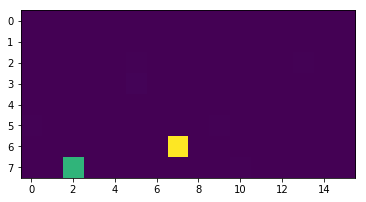

In [118]:
plt.imshow(val_predictions[40].reshape(8,16))

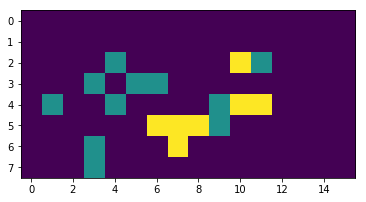

In [119]:
plt.imshow(hourly_targets_2017_c_val[40].reshape(8,16))

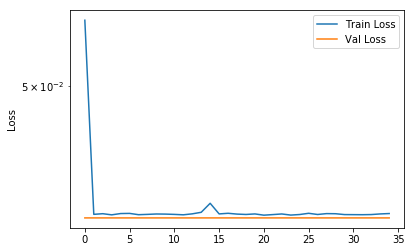

In [120]:
plt.plot(st_resnet2.history.history['loss'], label='Train Loss')
plt.plot(st_resnet2.history.history['val_loss'], label='Val Loss')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

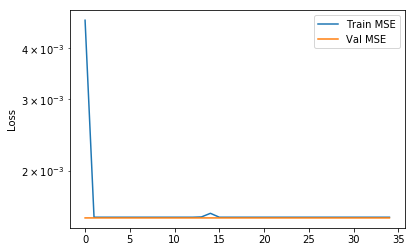

In [121]:
plt.plot(st_resnet2.history.history['mean_squared_logarithmic_error'], label='Train MSE')
plt.plot(st_resnet2.history.history['val_mean_squared_logarithmic_error'], label='Val MSE')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

In [124]:
test_results = st_resnet2.predict([mega_week_test, mega_daily_test, hourly_maps_2017_c_test])

#test_ground = hourly_maps_2017_c_test

In [123]:
x_feat_2017 = extra_feature_encode.loc['2017-01-01':]

## Training Combo Model

Below I combine the CNN model with the weather/time features model two different ways. One combination method was to concatonate the results of both models together and then use those values as inputs for the next model. The second combination method was to multiply the results of the first two models together to create inputs for the next model. 

My hypothesis is that the concatonate method will outperform the multiply method

In [125]:
# train meta model
map_predict = st_resnet2.predict([mega_week_val, mega_daily_val, hourly_maps_2017_c_val]) # predict

extra_feature_prediction = weather_network.predict(x_feat_2017.iloc[3000:3300])
extra_feature_prediction = extra_feature_prediction.reshape(-1,1)

combined_predictions = np.concatenate((map_predict,extra_feature_prediction), axis=1)
combined_dot_predictions = map_predict*extra_feature_prediction

In [126]:
combined_2hour_model_concat = MLPRegressor((128,128,128,),early_stopping=True, max_iter=500)
combined_2hour_model_concat.fit(combined_predictions, hourly_targets_2017_c_val)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(128, 128, 128), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [127]:
combined_2hour_model_mult = MLPRegressor((128,128,128,),early_stopping=True, max_iter=500)
combined_2hour_model_mult.fit(combined_dot_predictions, hourly_targets_2017_c_val)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(128, 128, 128), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [128]:
concat_train_predictions = combined_2hour_model_concat.predict(combined_predictions)
multiply_train_predictions = combined_2hour_model_mult.predict(combined_dot_predictions)
s = concat_train_predictions.reshape(300,8,16)
m = map_predict.reshape(300,8,16)

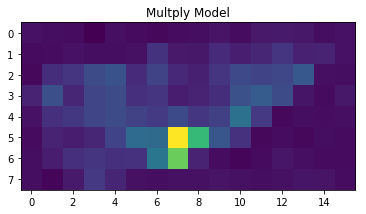

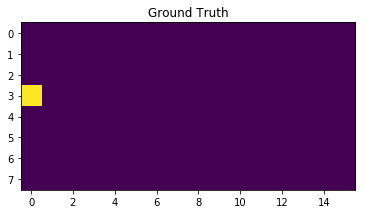

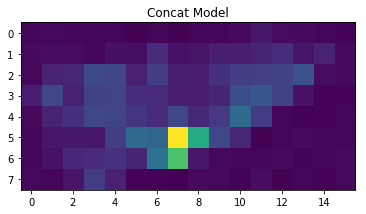

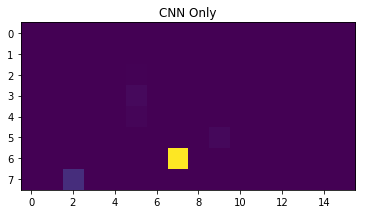

break


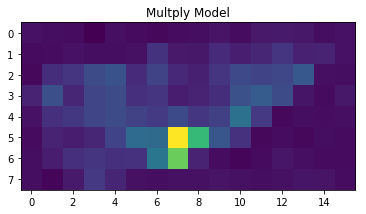

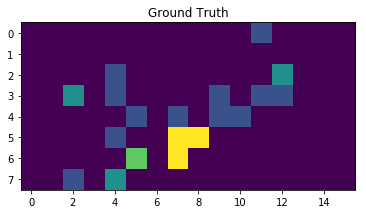

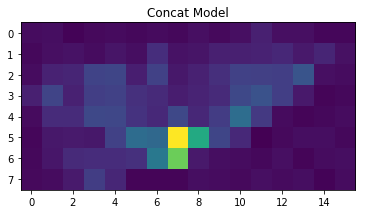

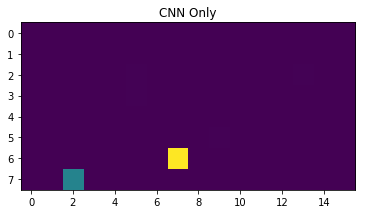

break


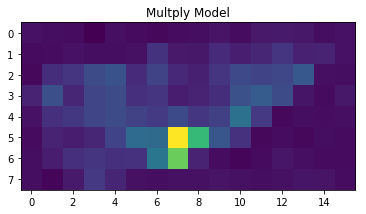

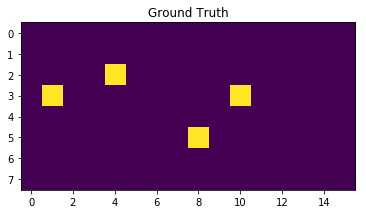

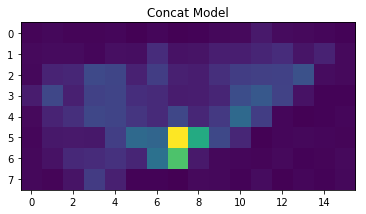

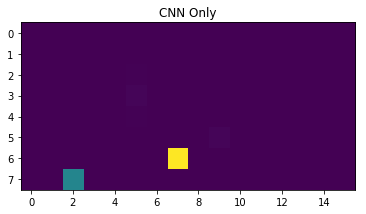

break


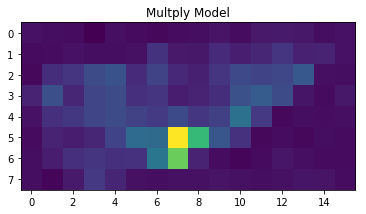

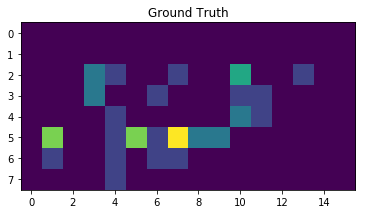

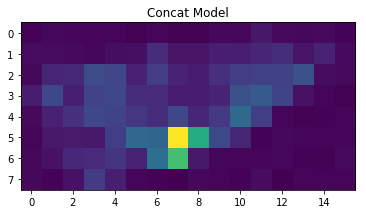

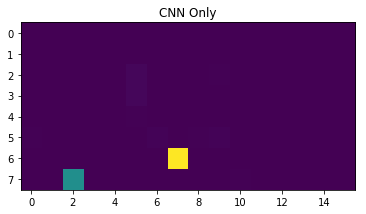

break


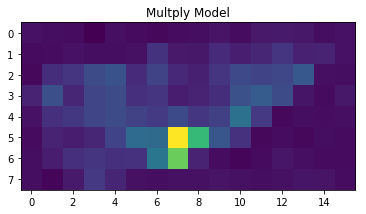

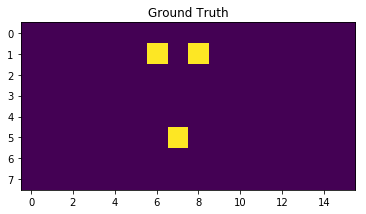

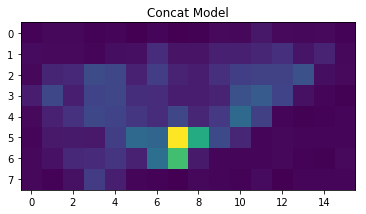

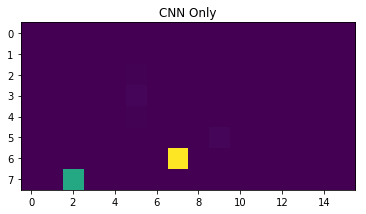

break


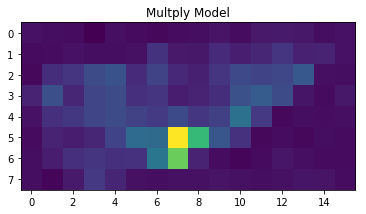

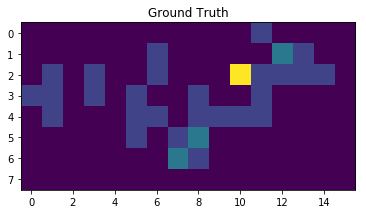

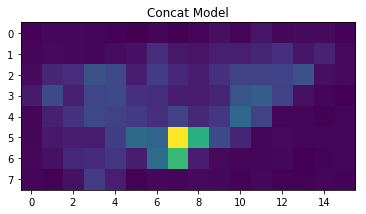

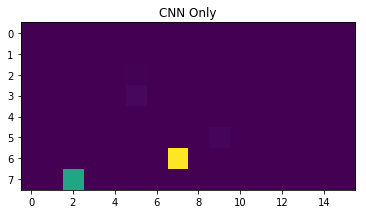

break


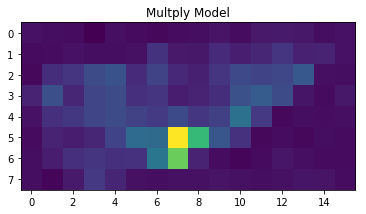

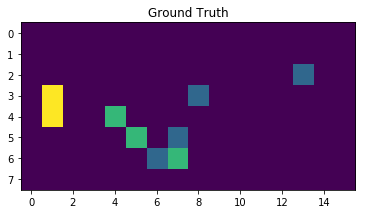

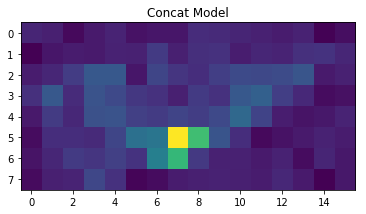

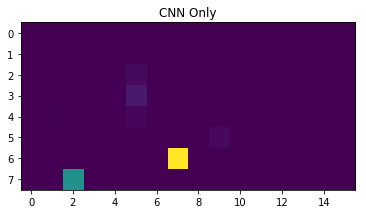

break


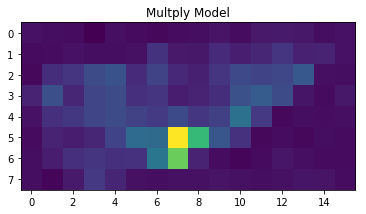

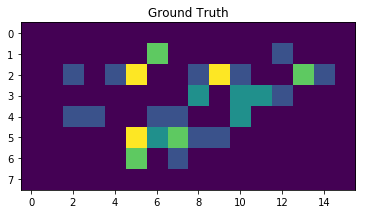

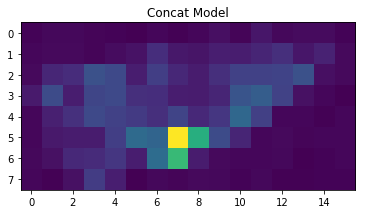

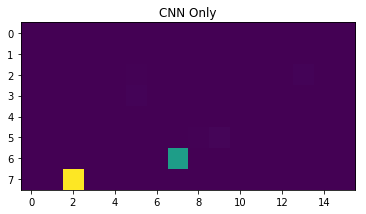

break


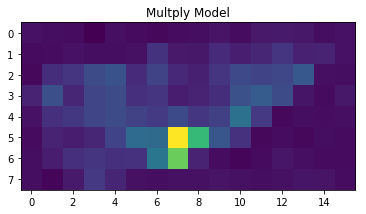

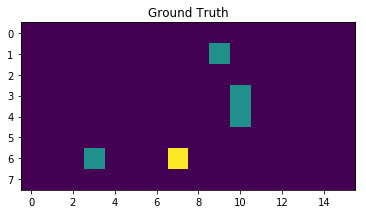

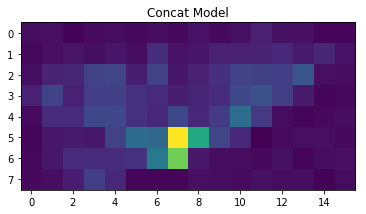

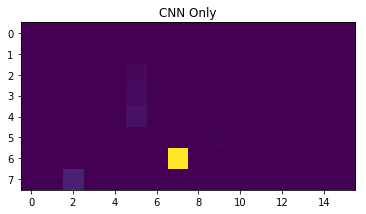

break


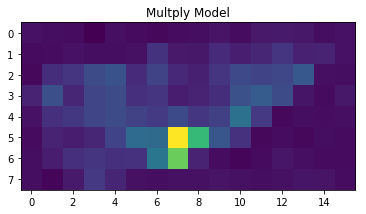

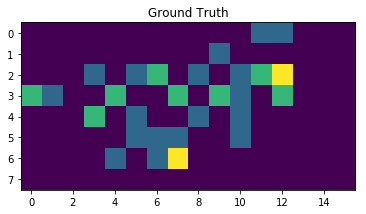

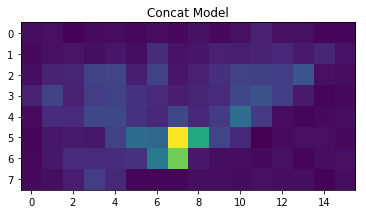

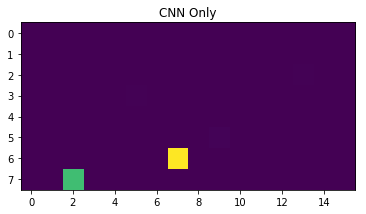

break


In [129]:
# some crime maps which represent some training predictions as well as the ground truth

for n in range(0,300,30):
    plt.imshow(multiply_train_predictions.reshape(300,8,16)[n])
    plt.title('Multply Model')
    plt.show()
    plt.imshow(hourly_targets_2017_c_val.reshape(300,8,16)[n])
    plt.title('Ground Truth')
    plt.show()
    plt.imshow(s[n])
    plt.title('Concat Model')
    plt.show()
    plt.imshow(m[n])
    plt.title('CNN Only')
    plt.show()
    print('break')

In [ ]:
# Test meta model

In [130]:
map_predict_test = st_resnet2.predict([mega_week_test, mega_daily_test, hourly_maps_2017_c_test]) # predict

extra_feature_prediction_test = weather_network.predict(x_feat_2017.iloc[3300:3600])
extra_feature_prediction_test = extra_feature_prediction_test.reshape(-1,1)

combined_predictions_test = np.concatenate((map_predict_test,extra_feature_prediction_test), axis=1)
combined_dot_predictions_test = map_predict_test*extra_feature_prediction_test

concat_test = combined_2hour_model_concat.predict(combined_predictions_test)

mult_test = combined_2hour_model_mult.predict(combined_dot_predictions_test)

In [131]:
concat_test.shape

(300, 128)

In [132]:
hourly_targets_2017_c_test.shape

(300, 128)

# Results
<a id='results'></a>
<a href='#top'>Back to Top</a>

In order to measure the effectivness of my models I am computing the mean squared error between the output of my models and ground truth.

cnn_truth -> mean squared error between the results of CNN model and ground truth

mult_truth -> mean squared error between the results of the multiplication meta-model and ground truth

concat_truth -> mean squared error between the results of the concatonation meta-model and ground truth

But what do these mean squared error values represent? More specifically what mean squared error values (computed between ground truth and model) would a good model have? In order to determine these baseline mean squared error values I have defined two simple models. The first simple model predicts that crime at a given time period is the same as crime one day previous. The second simple model predicts that crime at a given period is the same as the crime one week previous. 

Simple Models

prev_truth -> mean squared error between the results of simple model 1 and ground truth

week_prev_truth -> mean squared error between the results of simple model 2 and ground truth

In [133]:
# errors
cnn_truth = []
mult_truth = []
concat_truth = []
prev_truth = []
mean_truth = []
week_prev_truth = []
for p in range(300):
    c_t = mean_squared_error(hourly_targets_2017_c_test[p],map_predict_test[p])
    cnn_truth.append(c_t)
    m_t = mean_squared_error(hourly_targets_2017_c_test[p], mult_test[p])
    mult_truth.append(m_t)
    con_t = mean_squared_error(hourly_targets_2017_c_test[p], concat_test[p])
    concat_truth.append(con_t)
    if p > 12:
        pr_t = mean_squared_error(hourly_targets_2017_c_test[p], hourly_targets_2017_c_test[p-13])
        prev_truth.append(pr_t)
    elif p < 12:
        pr_t = 0
        prev_truth.append(pr_t)
        
    if p > 84:
        pr_t_w = mean_squared_error(hourly_targets_2017_c_test[p], hourly_targets_2017_c_test[p-85])
        week_prev_truth.append(pr_t_w)
    elif p < 84:
        pr_t_w = 0
        week_prev_truth.append(pr_t_w)
    
        
    mean_t = mean_squared_error(hourly_targets_2017_c_test[p], np.mean(hourly_targets_2017_c_val,axis=0))
    mean_truth.append(mean_t)
    

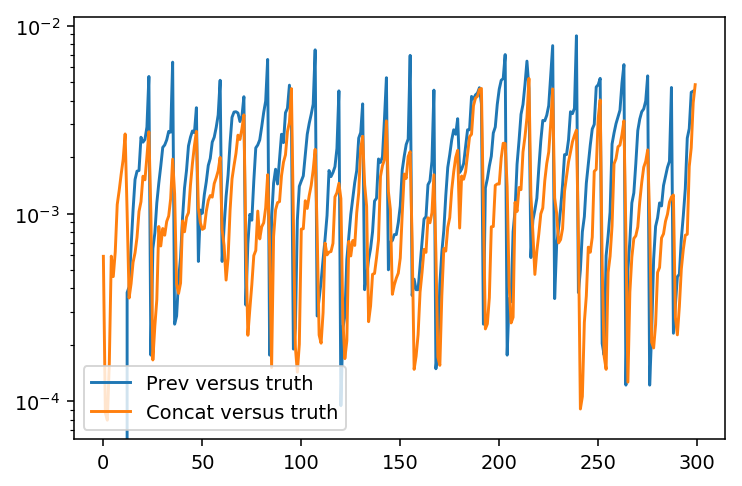

In [136]:
fig = plt.figure(dpi=140)
#plt.plot(range(300),cnn_truth, label='CNN Versus Truth')
#plt.plot(range(300),mean_truth, label='Mean versus truth')
plt.plot(range(299),prev_truth, label='Prev versus truth')
plt.plot(range(300),concat_truth, label='Concat versus truth')
#plt.plot(range(300),mult_truth, label='Mult versus truth')
plt.legend()
plt.yscale('log')
plt.show()

# Best Performance Measure

*****
In order to graphically represent the quality of the models, I have computed the difference between the mean squared error of the best developed model (called Concat/Truth) and the mean squared error of simple model 1 and simple model 2. Simple model 1 is is defined above as 'prev_truth' and simple model 2 is defined above as 'week_prev_truth'. When the best developed model scores below zero that indicates that my model outperformed the simple model in that period. This is a signal that the model is performing well. 

A note about graphs comparing with simple model 2 'week_prev_truth'. The first 84 periods of the graphs are just the mean squared error of the model being compared to. This essentially makes the results of the first 84 periods irrelevant for comparrison purposes. That is why the first 84 periods are missing from these graphs.

******

In [137]:
pre_cnn_mse = []
for x in range(299):
    # negitive scores good for model
    pre_cnn_mse.append(abs(cnn_truth[x]) - abs(prev_truth[x]))

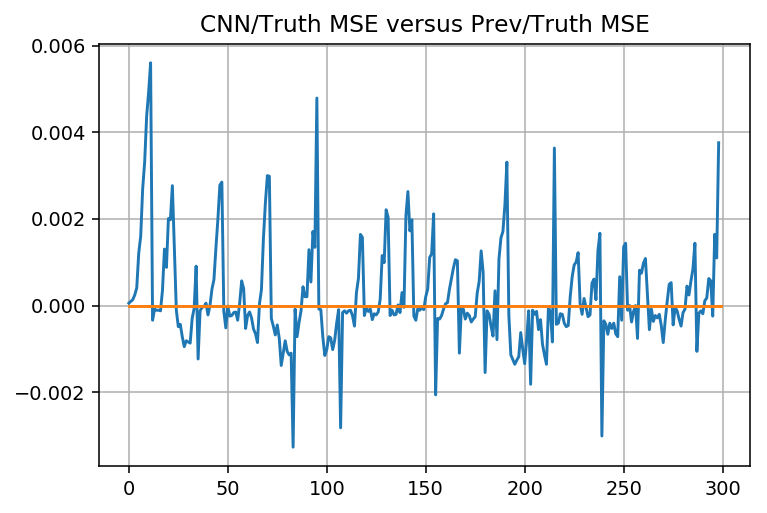

In [138]:
# test two dif models
fig = plt.figure(dpi=140)
plt.plot(pre_cnn_mse)
plt.plot(range(300),np.full((300,),0))
plt.grid()
plt.title('CNN/Truth MSE versus Prev/Truth MSE')
plt.show()

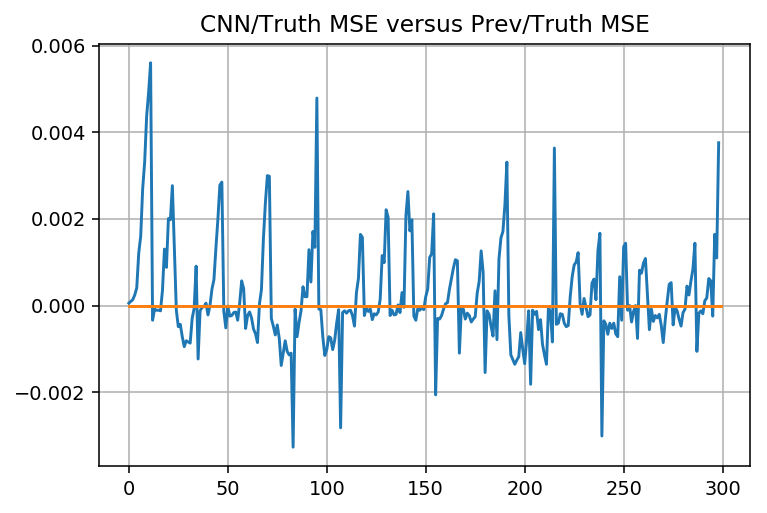

In [139]:
fig = plt.figure(dpi=140)
plt.plot(pre_cnn_mse)
plt.plot(range(300),np.full((300,),0))
plt.grid()
plt.title('CNN/Truth MSE versus Prev/Truth MSE')
plt.show()

In [140]:
prew_cnn_mse = []
for x in range(225):
    # negitive scores good for model
    prew_cnn_mse.append(abs(cnn_truth[x]) - abs(week_prev_truth[x]))

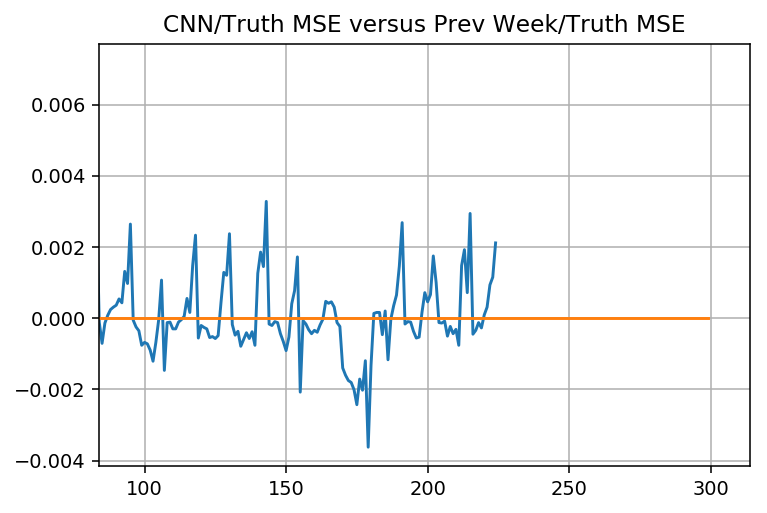

In [141]:
fig = plt.figure(dpi=140)
plt.plot(prew_cnn_mse)
plt.plot(range(300),np.full((300,),0))
plt.grid()
plt.xlim(xmin=84)
plt.title('CNN/Truth MSE versus Prev Week/Truth MSE')
plt.show()

In [143]:
mult_truth_mse = []
for x in range(299):
    # negitive scores good for model
    mult_truth_mse.append(abs(mult_truth[x]) - abs(prev_truth[x]))

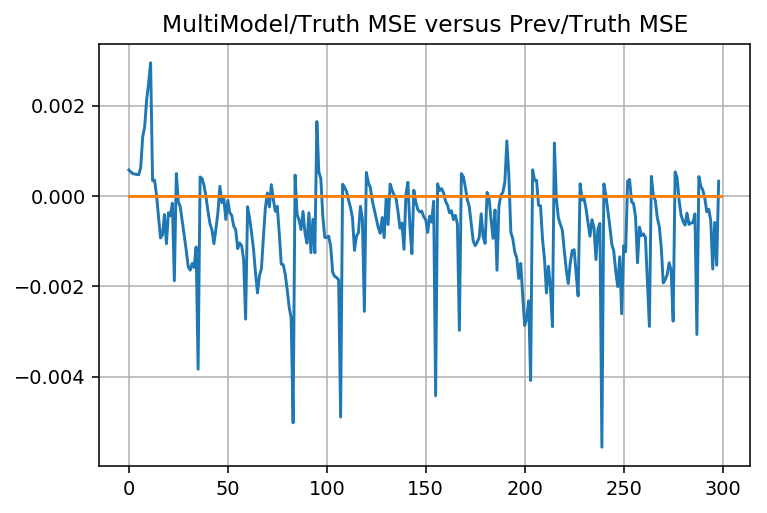

In [144]:
fig = plt.figure(dpi=140)
plt.plot(mult_truth_mse)
plt.plot(range(300),np.full((300,),0))
plt.grid()
plt.title('MultiModel/Truth MSE versus Prev/Truth MSE')
plt.show()

In [145]:
pre_concat_mse = []
for x in range(299):
    # negitive scores good for model
    pre_concat_mse.append(abs(concat_truth[x]) - abs(prev_truth[x]))

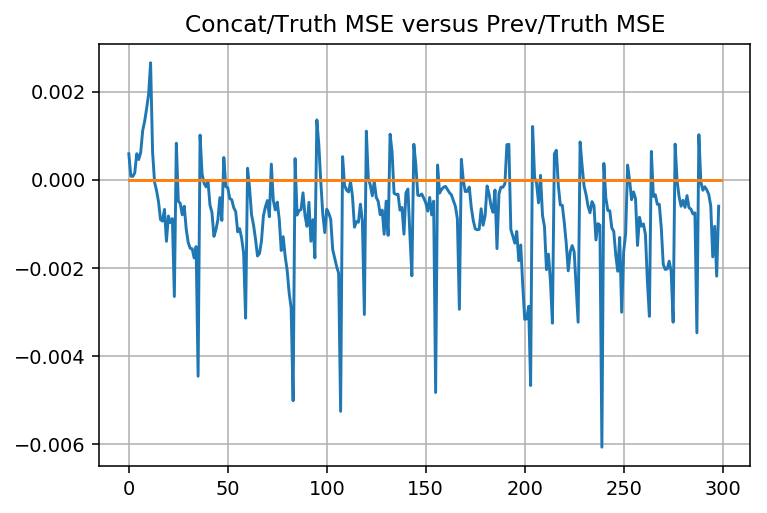

In [146]:
# test two dif models
fig = plt.figure(dpi=140)
plt.plot(pre_concat_mse)
plt.plot(range(300),np.full((300,),0))
plt.grid()
plt.title('Concat/Truth MSE versus Prev/Truth MSE')
plt.show()

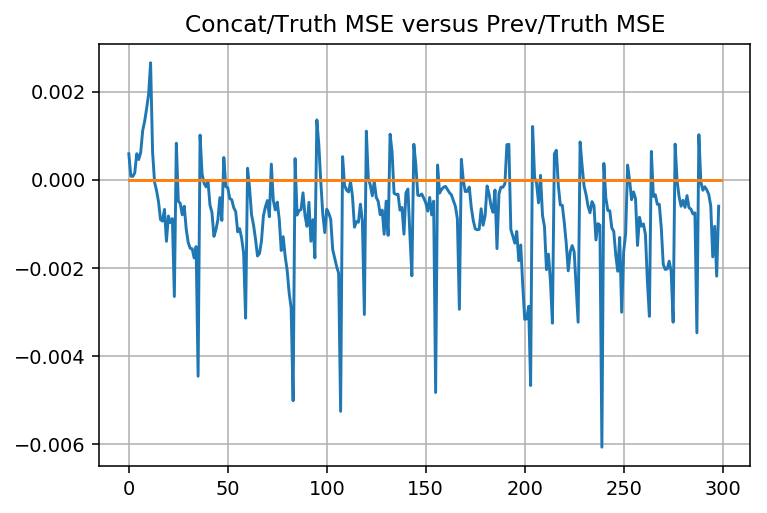

In [147]:
fig = plt.figure(dpi=140)
plt.plot(pre_concat_mse)
plt.plot(range(300),np.full((300,),0))
plt.grid()
plt.title('Concat/Truth MSE versus Prev/Truth MSE')
plt.show()

In [148]:
pre_w_concat_mse = []
for x in range(225):
    # negitive scores good for model
    pre_w_concat_mse.append(abs(concat_truth[x]) - abs(week_prev_truth[x]))

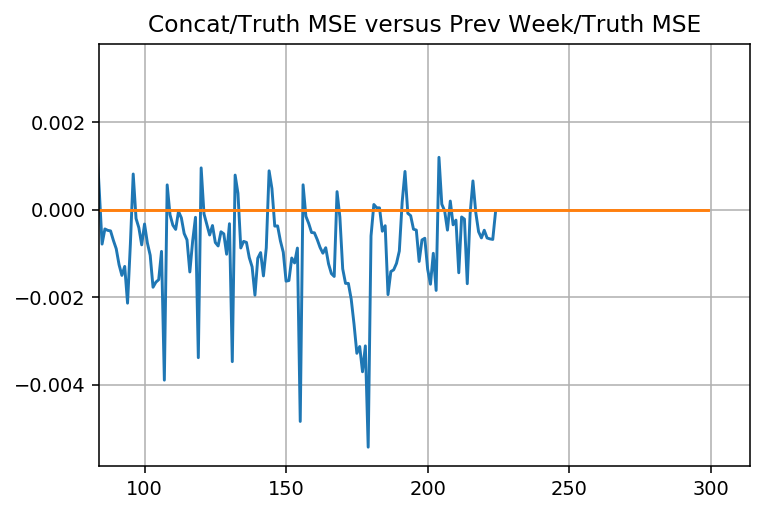

In [149]:
# seperate model
fig = plt.figure(dpi=140)
plt.plot(pre_w_concat_mse)
plt.plot(range(300),np.full((300,),0))
plt.grid()
plt.xlim(xmin=84)
plt.title('Concat/Truth MSE versus Prev Week/Truth MSE')
plt.show()

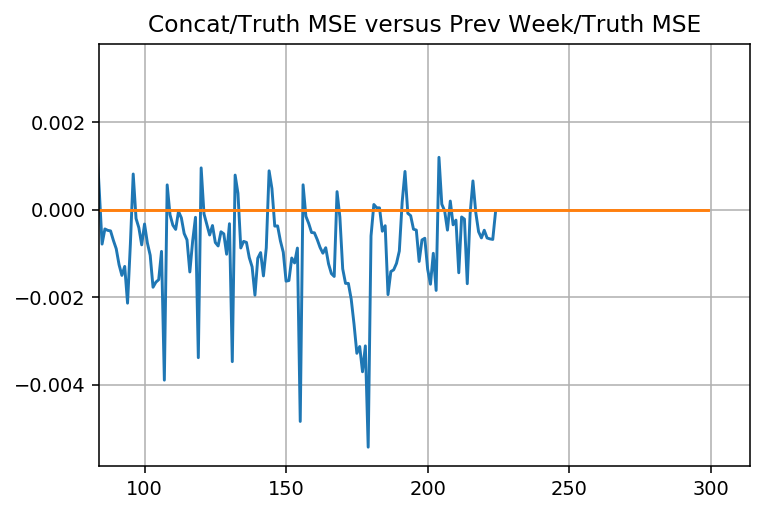

In [150]:
fig = plt.figure(dpi=140)
plt.plot(pre_w_concat_mse)
plt.plot(range(300),np.full((300,),0))
plt.grid()
plt.xlim(xmin=84)
plt.title('Concat/Truth MSE versus Prev Week/Truth MSE')
plt.show()

In [ ]:
with open('objs.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([hourly_targets_2017_c_test, map_predict_test, concat_test,mult_test], f)

## Below I evaluate the hourly performance of the best model ('Concat')

In [152]:
holder_dict = {}
cvt = {}
pvt = {}
for x in range(len(pre_concat_mse)):
    holder_dict[x] = pre_concat_mse[x]
    cvt[x] = concat_truth[x]
    pvt[x] = prev_truth[x]

In [153]:
new_df = pd.DataFrame.from_dict(holder_dict, orient='index')
cvt_df = pd.DataFrame.from_dict(cvt, orient='index')
pvt_df = pd.DataFrame.from_dict(pvt, orient='index')

In [154]:
holder_dict_2 = {}
for x in range(len(all_hourly_maps_c)):
    holder_dict_2[x] = all_hourly_maps_c[x].sum()

In [155]:
new_df_2 = pd.DataFrame.from_dict(holder_dict_2, orient='index')

In [168]:
# this checks to make sure that i am ploting the right number of points (i shouldnt plot 300 points, but instead 28)


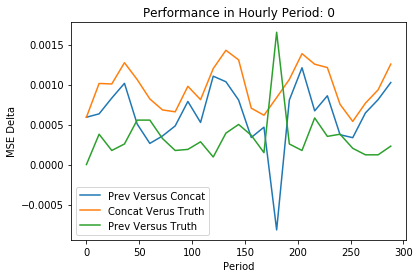

25


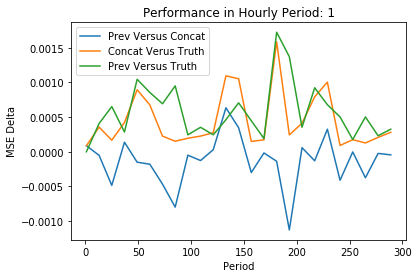

25


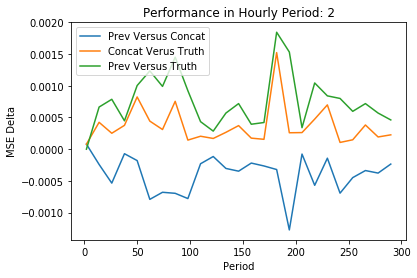

25


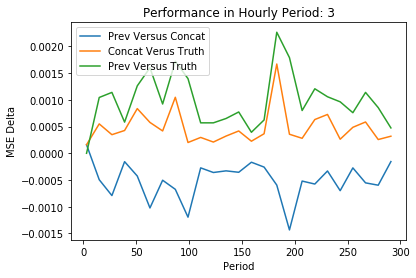

25


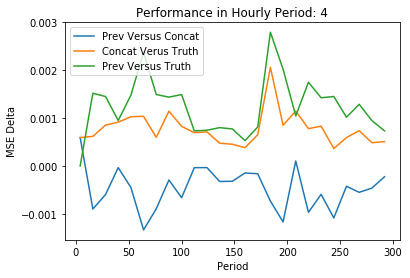

25


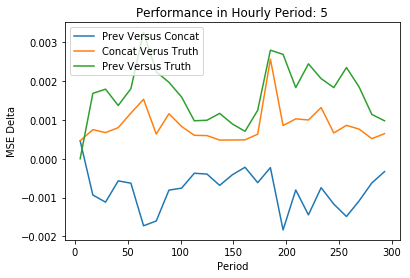

25


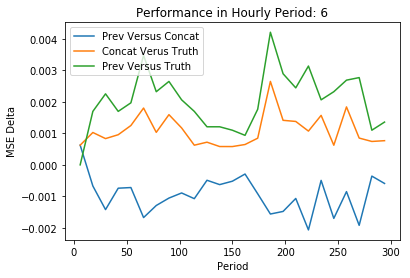

25


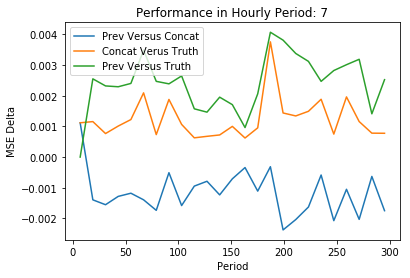

25


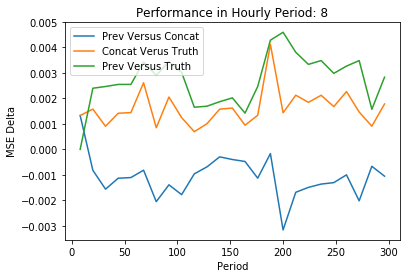

25


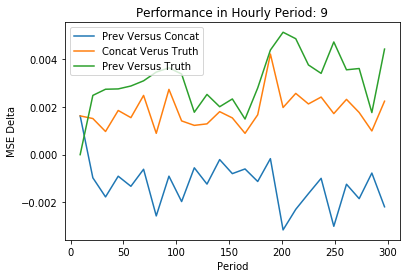

25


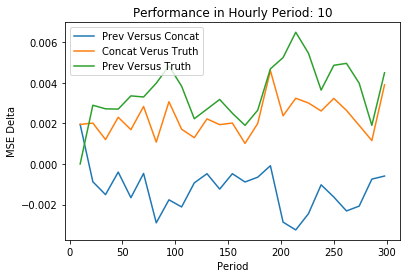

25


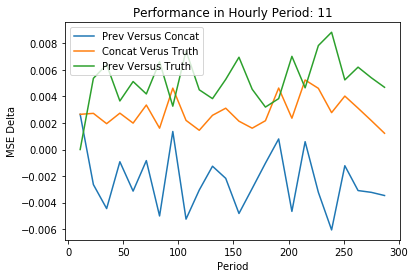

24


In [170]:
for x in range(12):
    plt.plot(new_df.iloc[x::12,:], label='Prev Versus Concat')
    plt.legend()

    plt.plot(cvt_df.iloc[x::12,:], label='Concat Verus Truth')
    plt.legend()

    plt.plot(pvt_df.iloc[x::12,:], label='Prev Versus Truth')
    plt.legend()
    plt.title(f'Performance in Hourly Period: {x}')
    plt.xlabel('Period')
    plt.ylabel('MSE Delta')
    plt.show()

# Discussion
<a id='disc'></a>
<a href='#top'>Back to Top</a>

The model produced a medicore result. In most cases my model outperformed the baseline models. Interestingly the reference paper did not have a baseline model to compare to. So I beleive the goal of replicating the reference paper was sucessful. 

In this iteration of the Notebook the CNN model did not properly converge. Generally the model does converge. Interestingly this iteration of the notebook with a non-converging CNN still performs decently. This suggests to me that the addition of the CNN model does not add utility to this model. 

Below is a plot of the difference between the MSE of the Concatanation Model and the MSE of the Previous Period Model. As you can see my model often outperforms the baseline, however it does not always outperform the baseline. A good starting point - but not a home run yet.

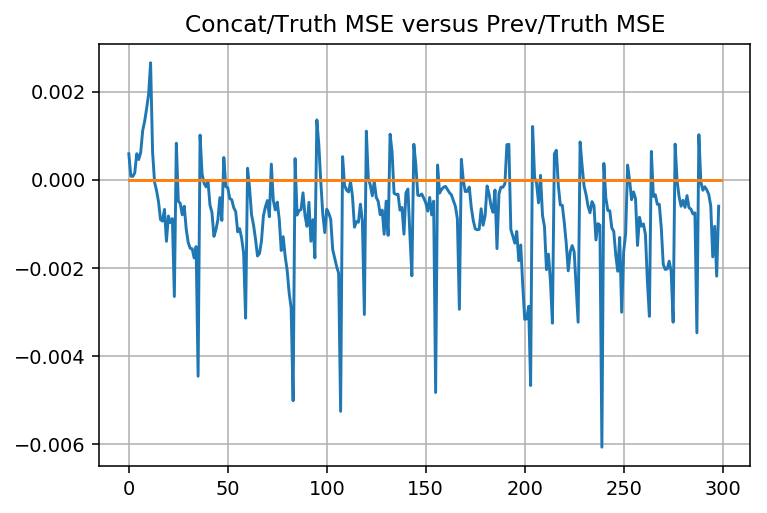

In [172]:
fig = plt.figure(dpi=140)
plt.plot(pre_concat_mse)
plt.plot(range(300),np.full((300,),0))
plt.grid()
plt.title('Concat/Truth MSE versus Prev/Truth MSE')
plt.show()

# Next Steps

1. Clean up code. A cleaner code base would make this model easier to generalize to other problems. 

2. Instead of feeding the CNN model into the meta-model, I could try feeding Sim